# Model Interpretation for Pretrained Deep Learning Models

This notebook applies model interpretability algorithms on pretrained deep learning models (in this case ResNet 50 or 101), using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image. It was provided by Captum Library. 
The originally used approoaches were
`Integrated Gradients` (w/ and w/o noise tunnel),  
`GradientShap`, `Occlusion`,
`LRP`. 
Since the latter is not compatible with ResNet, it was substituted by a modified version of `LIME`, still from the Captum Library.

In [2]:
import sys
sys.path.append('/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier') #modify with own path to the folder CNN_classifier

In [3]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Lime, LimeBase
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule
import pandas as pd

from CNN_classifier.cub import cub200
from CNN_classifier.models.models_for_cub import ResNet

from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import torchvision.transforms as T



/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/MLNLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1- Loading the model and the dataset


Loads the Resnet model we trained on CUB and sets it to eval mode 

**Note**: modify the path to the saved models in cell [8] line 8 and the path to the saved dataset in cell [9] line 2

In [4]:
#initialize ResNet-50 for CUB-200-2011
model = ResNet(pre_trained=False, n_class=200, model_choice=50)

#load the trained weights
checkpoint_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/model_save1/ResNet/ResNet50.pkl"  # Replace with your model's file path
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))

#remove `module.` prefix if present in the keys
if any(key.startswith("module.") for key in state_dict.keys()):
    state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

#load the state_dict into the model
model.load_state_dict(state_dict)

#set the model to evaluation mode
model = model.eval()

print("Loaded ResNet-50 trained on CUB-200-2011.")

/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/MLNLP/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/MLNLP/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2722199/3972385395.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

Loaded ResNet-50 trained on CUB-200-2011.


Please modify the classes_file_path with the path to the classes contained int CUB_200_2011/classes.txt

In [5]:
#define the path to the classes.txt file
classes_file_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/CUB_200_2011/classes.txt"  # Update to actual path

#load the CUB-200-2011 class labels into a dictionary
idx_to_labels = {}
with open(classes_file_path, "r") as file:
    for line in file:
        class_id, class_name = line.strip().split(" ")
        idx_to_labels[int(class_id) - 1] = class_name  # Adjust for 0-based indexing

#print a few labels to verify the procedure
print(f"Loaded {len(idx_to_labels)} class labels for CUB-200-2011.")
print(f"Sample labels: {list(idx_to_labels.items())[:5]}")

Loaded 200 class labels for CUB-200-2011.
Sample labels: [(0, '001.Black_footed_Albatross'), (1, '002.Laysan_Albatross'), (2, '003.Sooty_Albatross'), (3, '004.Groove_billed_Ani'), (4, '005.Crested_Auklet')]


Define transformers and normalizing functions for the image.
Then it also loads an image from the CUB folder that will be used for interpretation purposes.      
Please add a path in image_path to a photo in the dataset (CUB_200_2011/images/selected_pic)

Input tensor shape: torch.Size([1, 3, 448, 448])


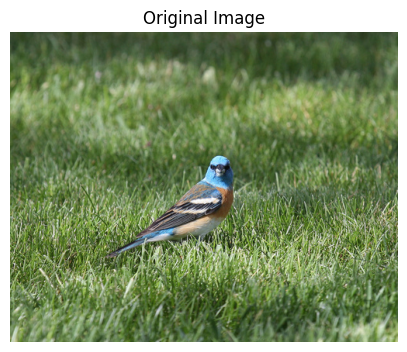

In [7]:
transform = transforms.Compose([
 transforms.Resize(448), #modified from 226 in the original code
 transforms.CenterCrop(448), #modified from 226 in the original code
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

image_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/CUB_200_2011/images/015.Lazuli_Bunting/Lazuli_Bunting_0001_14916.jpg"
img = Image.open(image_path).convert("RGB")

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

print(f"Input tensor shape: {input.shape}") #added final check

#display the original image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()


Predict the class of the input image

In [52]:
#pass the input through the model
output = model(input)

#spply softmax to get class probabilities
output = F.softmax(output, dim=1)

top5_scores, top5_indices = torch.topk(output, 5)

# Convert indices to labels
top5_labels = [idx_to_labels[idx.item()] for idx in top5_indices.squeeze()]

# Print the top 5 predictions
print("Top 5 Predictions:")
for i in range(5):
    print(f"{i+1}. {top5_labels[i]} (Confidence: {top5_scores.squeeze()[i].item():.4f})")

# Display the image
image = Image.open(image_path)
image.show() 


Top 5 Predictions:
1. 015.Lazuli_Bunting (Confidence: 0.9917)
2. 054.Blue_Grosbeak (Confidence: 0.0064)
3. 136.Barn_Swallow (Confidence: 0.0004)
4. 158.Bay_breasted_Warbler (Confidence: 0.0003)
5. 137.Cliff_Swallow (Confidence: 0.0003)


## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [53]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)


Predicted: 015.Lazuli_Bunting ( 0.9916526675224304 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

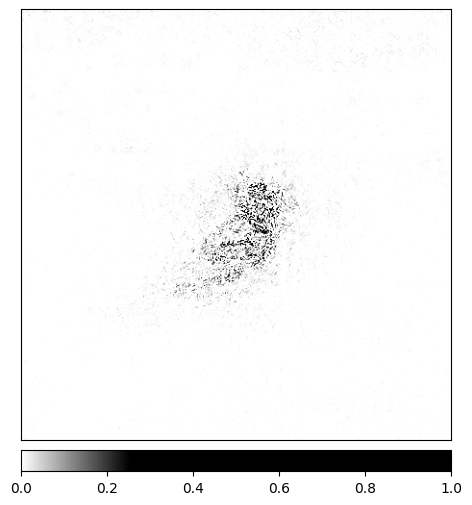

In [11]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

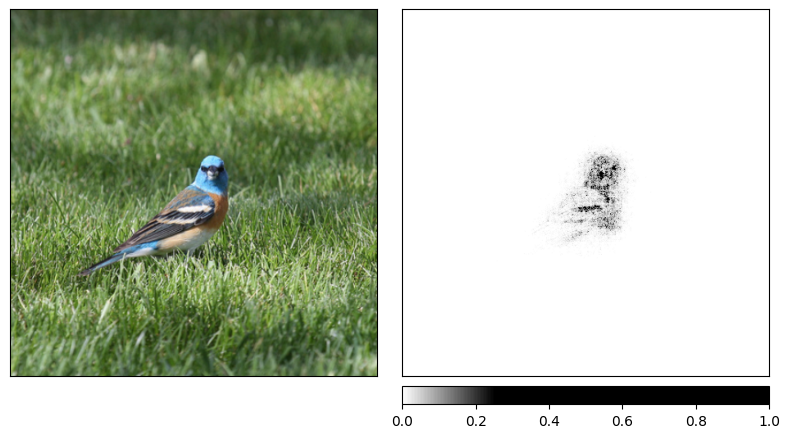

In [12]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

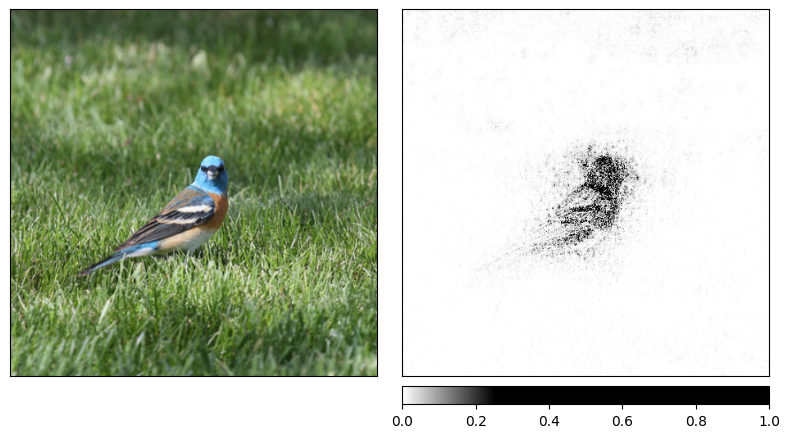

In [13]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## 3- Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [28]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

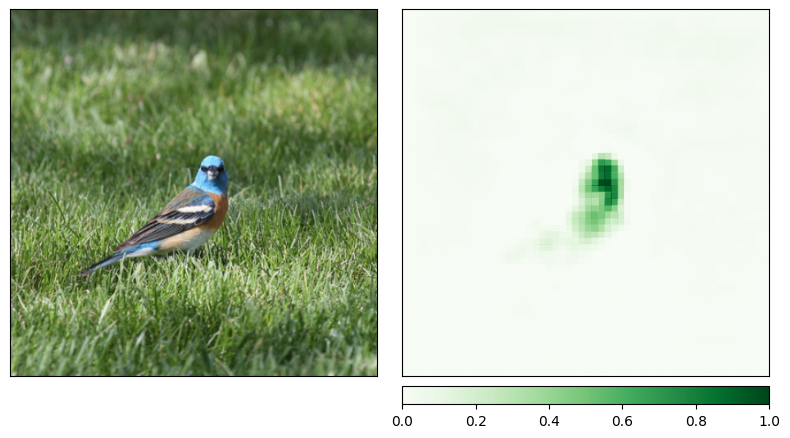

In [29]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)


The upper part of the bird, especially the beak, seems to be the most critical for the model to predict this class.

We can verify this further by occluding the image using a larger sliding window:

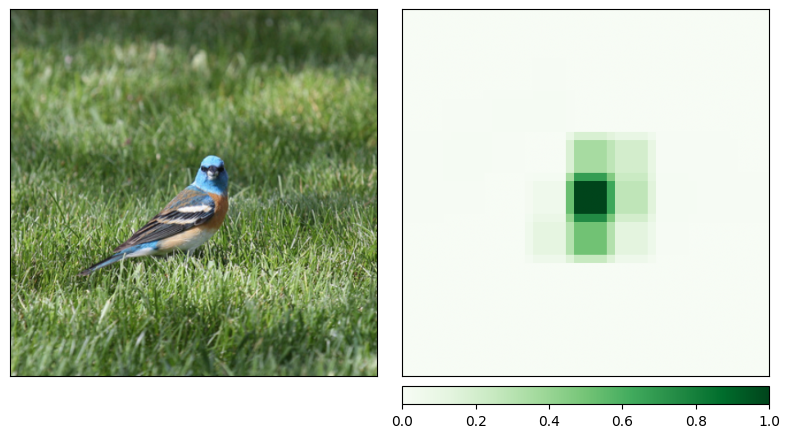

In [30]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

## 4- LIME 

The following approach, `LIME`, was taken from the Captum Library and modified, given that the CUB-200-2011 dataset does not provide segmentation masks, fundamental in the provided notebook.

In [35]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json
from captum.attr._core.lime import get_exp_kernel_similarity_function
import matplotlib.pyplot as plt

from captum.attr._core.lime import Lime
from captum.attr._core.lime import get_exp_kernel_similarity_function
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Print the 5 top k predictions for the selected image

In [72]:
#define the path to the image used in previous approaches
image_path = image_path

#apply the same transformations as used during training
transform = T.Compose([
    T.Resize((448, 448)),  # Ensure the correct input size for ResNet
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

#convert image to tensor
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to the correct device

# Ensure the model is in eval mode
# Ensure correct device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
model = model.to(device)

# Move input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass through the model
with torch.no_grad():
    outputs = model(input_tensor)  # Ensure both model and input are on the same device
    output_probs = F.softmax(outputs, dim=1).squeeze(0)  # Compute probabilities


Lime aims to explain the local behavior of an example, it will reweight the training samples according to their similarity distances. By default, Captum's Lime uses the exponential kernel on top of the consine distance. Here, it will change to euclidean distance instead which is more popular in vision.



In [73]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    model,  # Ensure this is the correct model variable used in the notebook
    interpretable_model=SkLearnLinearRegression(),  # Built-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)


ADDED: modified the original approach which perturbated single pixels, in order to perturbate bigger regions. This was done since originally LIME used segmentation masks to operate the perturbation, not available in this dataset.

In [1]:

#donvert image tensor to numpy array for segmentation
image_np = input_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

#generate superpixels
num_segments = 200
feature_mask = slic(image_np, n_segments=num_segments, compactness=10)

#convert to tensor format
feature_mask = torch.tensor(feature_mask, device=input_tensor.device).unsqueeze(0)

#run LIME again with the new feature mask
attrs = lr_lime.attribute(
    input_tensor,
    target=label_idx,
    feature_mask=feature_mask,
    n_samples=1000, 
    perturbations_per_eval=32,
    show_progress=True
).squeeze(0)

#visualize the new attributions
show_attr(attrs, image_np)


NameError: name 'input_tensor' is not defined